In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [3]:
bjd, flux, err, x, y, fwhmx, fwhmy, bg, exptime = np.loadtxt('gj1214.tsv', skiprows=500, unpack=True)
jd = bjd + 2450000

In [4]:
from batman import TransitParams
params = TransitParams()
params.per = 1.58040417
params.t0 = 2454980.74900
params.inc = 88.47
params.a = 14.45
params.rp = (1.365/100)**0.5 #0.1160
params.duration = 0.03620
params.b = 0.385
params.limb_dark = 'quadratic'
params.u = [0.258, -0.12]
params.w = 90
params.ecc = 0

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/time/core.py:880: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/time/core.py:881: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
/Users/bmmorris/git/friedrich/friedrich/lightcurve.py:889: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
/Users/bmmorris/git/friedrich/friedrich/lightcurve.py:890: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
/Users/bmmorris/git/friedrich/friedrich/lightc

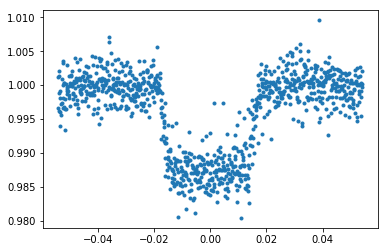

In [5]:
import sys

sys.path.insert(0, '/Users/bmmorris/git/friedrich/')
from friedrich.lightcurve import LightCurve, concatenate_transit_light_curves

lc = LightCurve(jd, flux)
split = LightCurve(**lc.mask_out_of_transit(params, oot_duration_fraction=1))
transits = split.get_transit_light_curves(params)
all_transits = concatenate_transit_light_curves(transits)

for transit in transits:
#     transit.fluxes /= np.median(transit_masked['fluxes'])

    condition = np.in1d(jd, transit.times.jd)
    
    X_all = np.vstack([x[condition], y[condition], fwhmx[condition], 
                       fwhmy[condition], bg[condition]]).T

    oot = np.ones_like(x[condition]).astype(bool)
    X = X_all[oot, :]

    omega = np.diag(err[oot]**2)
    omega_inv = np.linalg.inv(omega)

    V = np.linalg.inv(X.T @ omega_inv @ X)
    beta = V @ X.T @ omega_inv @ transit.fluxes[oot]

    regressed_lc = transit.fluxes - (X_all @ beta) + 1
    
    transit.fluxes = regressed_lc
    transit_masked = transit.mask_in_transit(params)
    transit.fluxes /= np.median(transit_masked['fluxes'])
    
#     transit.plot()
all_transits = concatenate_transit_light_curves(transits)

times = ((all_transits.times.jd - params.t0) % params.per)
times[times > params.per/2] -= params.per
all_fluxes = all_transits.fluxes[np.argsort(times)]
times = times[np.argsort(times)]
plt.plot(times, all_fluxes, '.')

In [6]:
yerr = all_fluxes[:300].std()

In [7]:
from copy import deepcopy
import batman

def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

def transit_model(theta, x):
    r0, r1, q1, q2, f0 = theta
    trial_params = deepcopy(params)
    trial_params.rp0 = r0
    trial_params.rp1 = r1
    trial_params.u = kipping_to_quadratic([q1, q2])
    trial_params.t0 = 0
    
    m = batman.TransitModel(trial_params, x, exp_time=1/60/24, supersample_factor=3)
    fluxes = f0 * m.light_curve(trial_params)
    
    return fluxes
    
def lnlike(theta, x, y, yerr):
    r0, r1, q1, q2, f0 = theta
    model = transit_model(theta, x) 
#     inv_sigma2 = 1.0/(yerr**2 + np.exp(2*lnf))
#     return -0.5*(np.sum((model - y)**2 *inv_sigma2 - np.log(inv_sigma2)))
    return -0.5*(np.sum((model - y)**2 / yerr**2))


def lnprior(theta):
    r0, r1, q1, q2, f0 = theta
    if 0 < r0 < 1 and 0.0 < r1 < 1 and 0 < q1 < 1 and 0 < q2 < 1 and 0 < f0 < 1.5:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


ndim, nwalkers = 5, 10
#pos = [[params.rp, params.rp, 0] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
pos = []

q1 = (params.u[0] + params.u[1])**2
q2 = 0.5 * params.u[0] / (params.u[0] + params.u[1])

while len(pos) < nwalkers: 
    trial_pos = [params.rp, params.rp, q1, q2, 1] + 1e-2*np.random.randn(ndim)
    if np.isfinite(lnprior(trial_pos)):
        pos.append(trial_pos)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, all_fluxes, yerr),
                                threads=4)

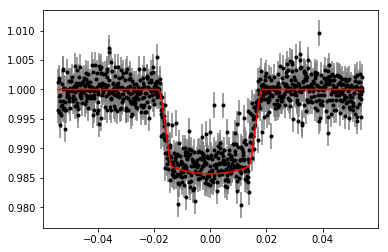

In [8]:
init_f = transit_model([params.rp, params.rp, q1, q2, 1], times)

plt.errorbar(times, all_fluxes, yerr, fmt='.', color='k', ecolor='gray')
plt.plot(times, init_f, 'r', zorder=10)

In [9]:
sampler.run_mcmc(pos, 10000); 

In [10]:
# np.savetxt('gj1214_samples.txt', sampler.flatchain)

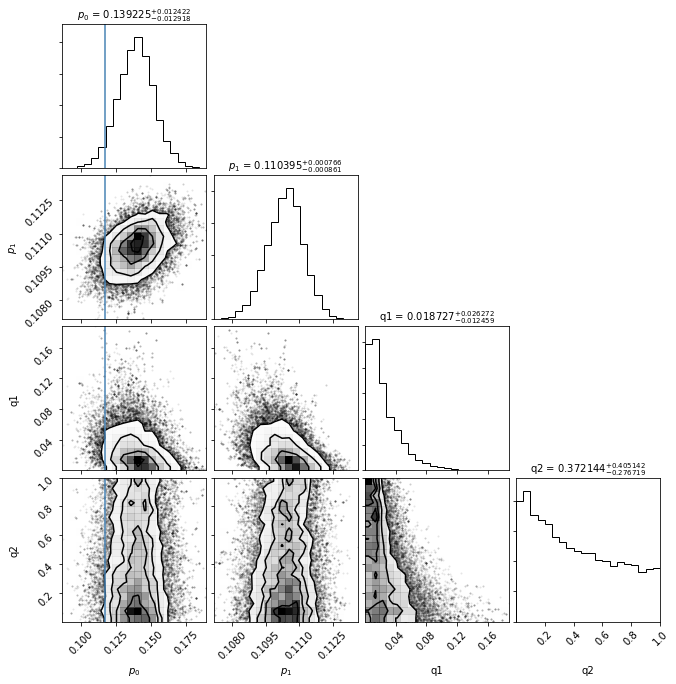

In [23]:
from corner import corner

corner(sampler.chain[:, 5000:, :-1].reshape((-1, ndim-1)), truths=[params.rp, params.rp, None, None], 
       labels=['$p_0$', '$p_1$', 'q1', 'q2'], show_titles=True, #fig=fig, 
       title_fmt='.6f', title_kwargs=dict(fontsize=10));

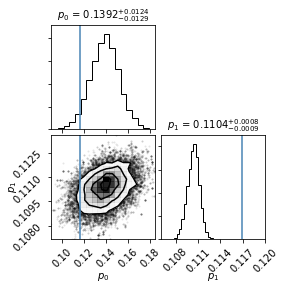

In [22]:
from corner import corner

fig, ax = plt.subplots(2, 2, figsize=(4, 4))
corner(sampler.chain[:, 5000:, :2].reshape((-1, ndim-3)), truths=[params.rp, params.rp], 
       labels=['$p_0$', '$p_1$'], fig=fig, show_titles=True, title_fmt='.4f', title_kwargs=dict(fontsize=10));

for i, axis in enumerate(fig.axes):
    axis.set_xlim([0.09, 0.185])
    if i == 3: 
        axis.set_xlim([0.106, 0.12])
plt.savefig('corner_quad_gj1214.pdf', bbox_inches='tight')

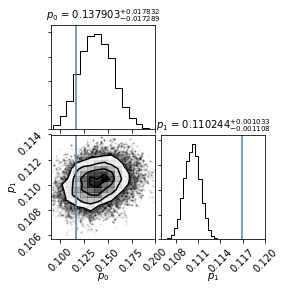

In [54]:
# from corner import corner

# nburnin = 5000
# fig, ax = plt.subplots(2, 2, figsize=(4, 4))
# corner(sampler.chain[:, 5000:, :2].reshape((-1, ndim-2)), truths=[params.rp, params.rp], 
#        labels=['$p_0$', '$p_1$'], fig=fig, show_titles=True, title_fmt='.6f', title_kwargs=dict(fontsize=10));

# for i, axis in enumerate(fig.axes):
#     axis.set_xlim([0.09, 0.2])
#     if i == 3: 
#         axis.set_xlim([0.106, 0.12])
# plt.savefig('corner_quad_gj1214.pdf', bbox_inches='tight')

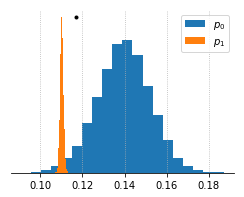

In [17]:
plt.figure(figsize=(4, 3))
fmax = 0
for p, label in zip(sampler.chain[:, 5000:, :2].reshape((-1, ndim-3)).T, 
                    ['$p_0$', '$p_1$']):
    n, _, _ = plt.hist(p, bins=20, histtype='stepfilled', label=label)
    fmax = max([n.max(), fmax])
ax = plt.gca()
ax.grid(ls=':')
ax.legend()
ax.set(yticks=[])

# Gillon 2014
depth, depth_err = 1.365/100, 0.011/100
rprs_lit, rprs_err_lit = depth**0.5, 0.5*depth_err/np.sqrt(depth)

ax.errorbar(rprs_lit, fmax, xerr=rprs_err_lit, fmt='.', color='k')

for s in ['right', 'top', 'left']:
    ax.spines[s].set_visible(False)
plt.savefig('gj1214_agreement.pdf', bbox_inches='tight')

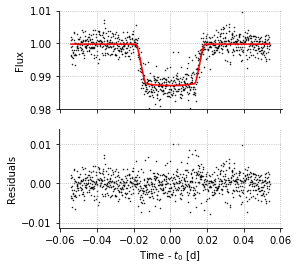

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
ax[0].scatter(times, all_fluxes, marker='.', s=1, 
              color='k')

i = np.argmax(sampler.flatlnprobability, axis=0)
ax[0].plot(times, transit_model(sampler.flatchain[i, :], times), color='r')

ax[1].scatter(times, all_fluxes - transit_model(sampler.flatchain[i, :], times), 
              marker='.', s=1, 
              color='k')

ax[0].set_ylim([0.98, 1.01])
#ax[1].set_ylim([-1000, 1000])

ax[0].set_ylabel('Flux')
ax[1].set(xlabel='Time - $t_0$ [d]', ylabel='Residuals')

for axis in ax:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.grid(ls=':')

fig.savefig('gj1214_residuals.pdf', bbox_inches='tight', dpi=250)

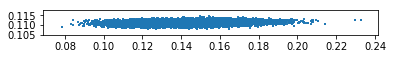

In [11]:
plt.scatter(sampler.chain[:, 5000:, 0], sampler.chain[:, 5000:, 1], marker=',', s=1)
plt.gca().set_aspect(1)

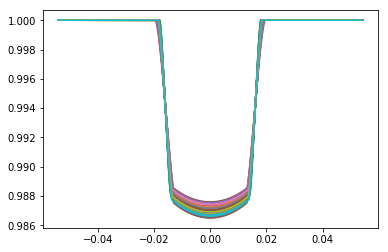

In [13]:


for i in np.random.randint(5000-sampler.chain.shape[0], size=10):
    samples_i = sampler.chain[:, (5000+i), :]
    for sample in samples_i: 
        plt.plot(times, transit_model(sample, times))

(array([    33.,    393.,   2507.,   8610.,  17626.,  21157.,  13704.,
          4890.,    950.,    130.]),
 array([ 0.79381203,  0.88345501,  0.973098  ,  1.06274098,  1.15238396,
         1.24202695,  1.33166993,  1.42131291,  1.5109559 ,  1.60059888,
         1.69024186]),
 <a list of 10 Patch objects>)

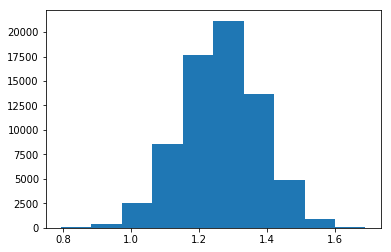

In [12]:
p0 = sampler.chain[:, 3000:, 0].ravel()
p1 = sampler.chain[:, 3000:, 1].ravel()

plt.hist(p0/p1)